# Your Very First Machine Learning (ML) Model: Logistic Regression

Dataset: [College Student Placement Factors Dataset](https://www.kaggle.com/datasets/sahilislam007/college-student-placement-factors-dataset) (`data/college_student_placement_dataset.csv`)

In [28]:
from IPython.display import display

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

## Constants

It is a good programming practice to use constants to avoid repetition errors and to save yourself the effort of retyping the expression by _centralizing_ semantically identical values.

`DATASET_PATH` identifies the path to the dataset being loaded and operated on. `RANDOM_STATE` makes otherwise random operations reproducible run after run. Keep whatever value you set it to unless you want slightly different results.

In [29]:
DATASET_PATH = '../data/college_student_placement_dataset.csv'
RANDOM_STATE = 45

## Preliminary Inspection

See what the raw file looks like!

In [30]:
# Look at the first 5 lines of theraw contents of the file first.

with open(DATASET_PATH, 'r') as file:
    for line_number in range(5):
        if line := file.readline():
            print(line)
        else:
            break # Stop; there are less than 5 lines.


College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement

CLG0030,107,6.61,6.28,8,No,8,8,4,No

CLG0061,97,5.52,5.37,8,No,7,8,0,No

CLG0036,109,5.36,5.83,9,No,3,1,1,No

CLG0055,122,5.47,5.75,6,Yes,1,6,1,No



## Preliminary Load

Load the data. This is not the final form of the data which will be used, but it’s a `DataFrame` for further inspection so we can decide what to do with it next.

In [31]:
# Load the dataset into a pandas dataframe.

df = pd.read_csv(DATASET_PATH)
df

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No
...,...,...,...,...,...,...,...,...,...,...
9995,CLG0021,119,8.41,8.29,4,No,1,8,0,Yes
9996,CLG0098,70,9.25,9.34,7,No,0,7,2,No
9997,CLG0066,89,6.08,6.25,3,Yes,3,9,5,No
9998,CLG0045,107,8.77,8.92,3,No,7,5,1,No


## Null Values Check
Inspect which varibles may be good / not good for using as features based on null values. 


In [32]:
# Identify which columns have null values. 

print("Null values per column:")
print(df.isnull().sum())
print("Total null values:", df.isnull().sum().sum())

Null values per column:
College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64
Total null values: 0


## Duplicate Rows Check
If so, remove the duplicates.

In [33]:
# Check to see if our data has any duplicate rows.
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
    print(f"New dataset shape: {df.shape}")
else:
    print("No duplicate rows found")


Number of duplicate rows: 0
No duplicate rows found


Many clean… 😐

## Categorical Categories

What are the categories for the categorial-looking (i.e., non-numeric) columns?

In [34]:
print("Dataset info:")
print(df.info())


categorical_cols = ['Internship_Experience', 'Placement']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(df[col].value_counts())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB
None
Unique values in Internship_Experience:
Internship_Experience
No     6036
Yes    3964
Name: count, dtype: int64
Unique values in Placement:
Placement
No     8341
Yes    1659

## Feature Engineering

Non-numeric columns containing `'Yes'` and `'No'` do not work with logistic regression. Binary categories can be converted an integral type (`int`) with a value of 0 or 1.

In [35]:
df['Internship_Experience'] = df['Internship_Experience'].map({'No': 0, 'Yes': 1})
df['Placement'] = df['Placement'].map({'No': 0, 'Yes': 1})
print(df.head())
print(df.dtypes)

  College_ID   IQ  Prev_Sem_Result  CGPA  Academic_Performance  \
0    CLG0030  107             6.61  6.28                     8   
1    CLG0061   97             5.52  5.37                     8   
2    CLG0036  109             5.36  5.83                     9   
3    CLG0055  122             5.47  5.75                     6   
4    CLG0004   96             7.91  7.69                     7   

   Internship_Experience  Extra_Curricular_Score  Communication_Skills  \
0                      0                       8                     8   
1                      0                       7                     8   
2                      0                       3                     1   
3                      1                       1                     6   
4                      0                       8                    10   

   Projects_Completed  Placement  
0                   4          0  
1                   0          0  
2                   1          0  
3                 

❔ When should you use this versus using `pd.get_dummies`?

# Visualization with `sns.pairplot`

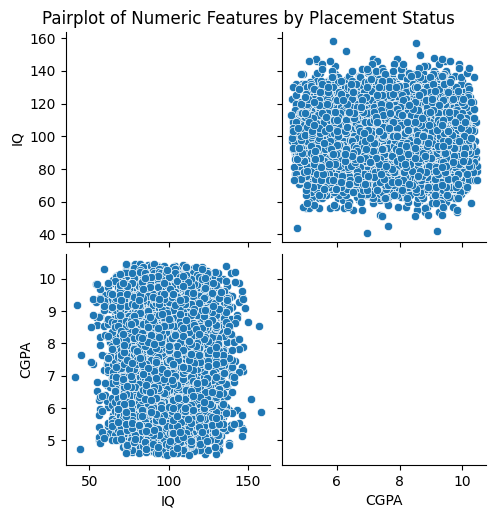

In [36]:
# Use sns.pariplot to visualize.

numeric_cols = ['IQ', 'CGPA']

sns.pairplot(df[numeric_cols], diag_kind='line')
plt.suptitle('Pairplot of Numeric Features by Placement Status', y=1.02)
plt.show()

## Feature Selection 

Choose the columns corresponding to the features _IQ_ and _internship experience_ to be your `X`. Target _placement_ as your `y`.

In [37]:
X = df[['IQ', 'Internship_Experience']]

y = df['Placement']


## Split to Testing and Training Datasets 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print('X_train: %d rows, %d columns' % X_train.shape)
print('X_test: %d rows, %d columns' % X_test.shape)
print('y_train: %d rows, 1 column' % y_train.shape)
print('y_test: %d rows, 1 column' % y_test.shape)

X_train: 8000 rows, 2 columns
X_test: 2000 rows, 2 columns
y_train: 8000 rows, 1 column
y_test: 2000 rows, 1 column


## Build and train your model

Initialize an empty Logistic Regression model, and then fit your model to your training data. 

In [39]:
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,45
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluation

Make predictions with your test data and save the predictions as `y_pred`.

In [40]:
y_pred = model.predict(X_test)

y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(2000,))

Calculate and print the accuracy, precision, recall, and F1 scores of your model.

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score: %f" % accuracy)
print("Precision Score: %f" % precision)
print("Recall Score: %f" % recall)
print('F1 Score: %f' % f1)

Accuracy Score: 0.829000
Precision Score: 0.333333
Recall Score: 0.030120
F1 Score: 0.055249


Plot a confusion matrix of your predicted results.

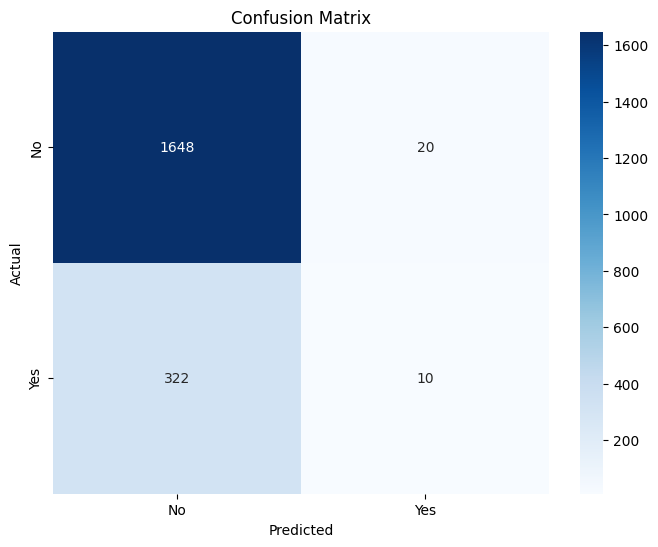

In [42]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

How many true positives and true negatives did your model get?

In [43]:
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, y_pred).ravel()

print('True Negatives: %d' % true_negatives)
print('True Positives: %d' % true_positives)

True Negatives: 1648
True Positives: 10


Such awful 😞

# What is the Most Important Feature
 
Use `statsmodel` to create a summary report. Interpret the results.

In [44]:
X_with_const = sm.add_constant(X)

logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.406531
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Placement   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0.09524
Time:                        00:56:27   Log-Likelihood:                -4065.3
converged:                       True   LL-Null:                       -4493.3
Covariance Type:            nonrobust   LLR p-value:                1.408e-186
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.4077      0.224    -33.142      0.000      -7.846      -6.

# Extra Credit: Use your brain and make a better model (as in better scores).



Improved Model Scores:
Accuracy Score: 0.906000
Precision Score: 0.772727
Recall Score: 0.614458
F1 Score: 0.684564


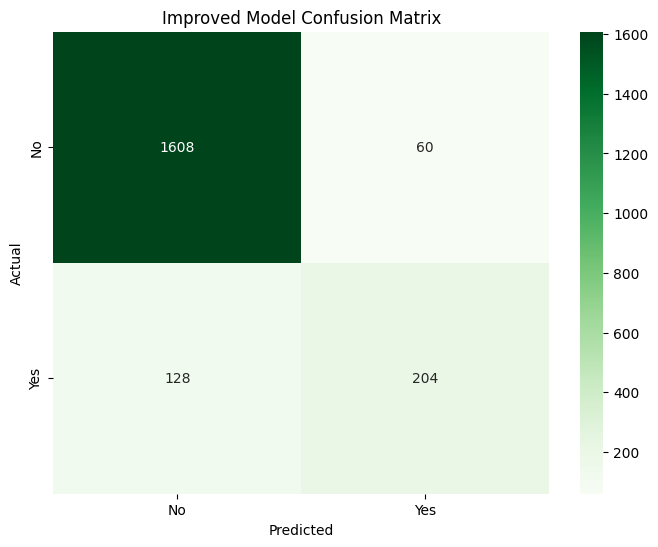

In [45]:
X_improved = df[['IQ', 'Internship_Experience', 'CGPA', 'Communication_Skills', 'Projects_Completed']]

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_improved, y, test_size=0.2, random_state=RANDOM_STATE)

model_improved = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

model_improved.fit(X_train_imp, y_train_imp)

y_pred_improved = model_improved.predict(X_test_imp)

accuracy_imp = accuracy_score(y_test_imp, y_pred_improved)
precision_imp = precision_score(y_test_imp, y_pred_improved)
recall_imp = recall_score(y_test_imp, y_pred_improved)
f1_imp = f1_score(y_test_imp, y_pred_improved)

print("Improved Model Scores:")
print("Accuracy Score: %f" % accuracy_imp)
print("Precision Score: %f" % precision_imp)
print("Recall Score: %f" % recall_imp)
print('F1 Score: %f' % f1_imp)

cm_improved = confusion_matrix(y_test_imp, y_pred_improved)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Improved Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()